In [1]:
import sys 
sys.path.append('../scripts/')
from qmdp import *
from sensor_reset_mcl import *

In [9]:
class PfcAgent(QmdpAgent): 
    def __init__(self, time_interval, estimator, goal, puddles, sampling_num=10, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, power=2): 
        super().__init__(time_interval, estimator, goal, puddles, sampling_num, widths, puddle_coef, lowerleft, upperright)
        
        self.power = power #追加
        
    def evaluation(self, action, indexes):
        ans = 0.0
        for i in indexes:
            q = self.dp.action_value(action, i, out_penalty=False)
            v = self.dp.value_function[i] if abs(self.dp.value_function[i]) > 0.0 else 1e-10 #ゼロ割防止
            ans += q/(abs(v)**self.power)
            
        return ans/len(indexes)
        
    def policy(self, pose, goal=None):
        for p in self.estimator.particles:
            if self.goal.inside(p.pose): p.weight *= 1e-10
        self.estimator.resampling()
        
        return  super().policy(pose, goal)

<IPython.core.display.Javascript object>


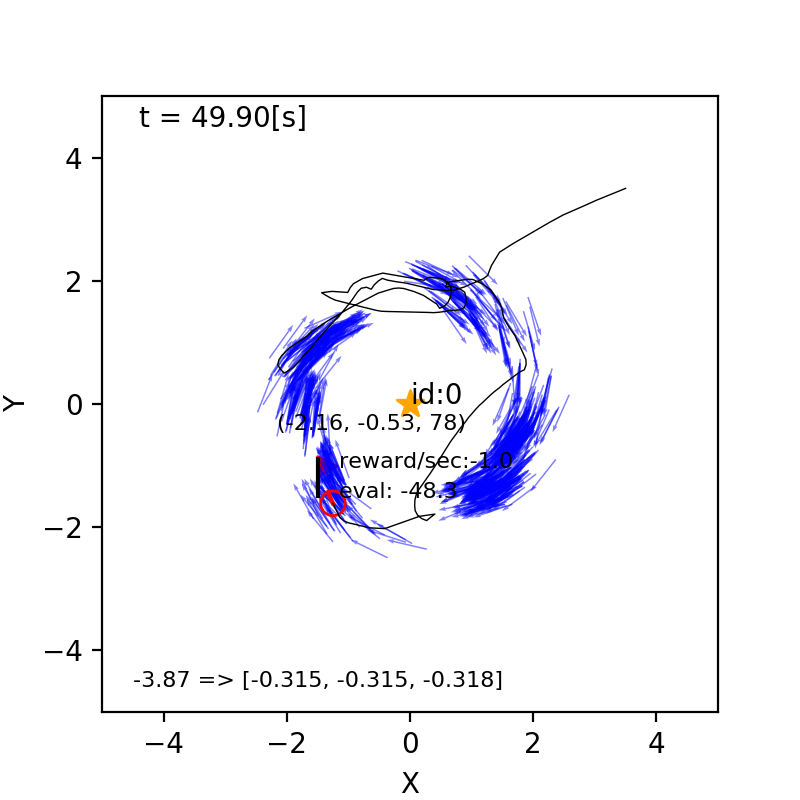

In [18]:
def trial(animation):
    time_interval = 0.1
    world = PuddleWorld(300, time_interval, debug=not animation) 

    ##ランドマークの追加（1個だけ）##
    m = Map()
    m.append_landmark(Landmark(0,0))
    world.append(m) 
    
    ##ゴール##
    goal = Goal(-1.5,-1.5)
    world.append(goal)
    
    ##ロボットを作る##
    pf = ResetMcl(m, [-10, -10, 0], 1000)              #誘拐状態から始める（すぐセンサリセットされる）
    a = PfcAgent(time_interval, pf, goal, [])           #水たまりはナシに。空のリストを渡す
    r = Robot(np.array([3.5, 3.5, np.pi]).T, sensor=Camera(m), agent=a, color="red")

    world.append(r)
    world.draw()
#    world.ani.save('/tmp/anm.gif', writer='imagemagick', fps=1)
trial(True)